In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_json("../100k_1/2023-06-14_05-31-05_094487_results.log", lines=True)

In [3]:
df[df.operator.apply(lambda x: 'Filenotfound' in x)].head()

,dataset,join,operator,model,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,complexity,selectivity,times,num_cores,data_characteristics,profile_times,times_std,times_mean


In [4]:
df = df[~df.operator.apply(lambda operator_str: any([x in operator_str for x in ['Materialization', 'Noop']]))]


In [5]:
# handle failures
df['operator_original'] = df.operator
df['operator']= df.operator.apply(lambda operator_str: operator_str.split("= fail:")[0])
scalar_ops = ['Left multiply', 'Row summation' , 'Column summation' , 'Left multiply T' , 'Row summation T', 'Column summation T', 'Right multiply','Right multiply T']
df['operator_type'] = df.operator.apply(lambda operator_str: 'scalar' if operator_str in scalar_ops else operator_str)

In [6]:
from collections import defaultdict
materialized_complexity_dict = defaultdict(lambda: 0)
for dataset, operator, complexity in df[df.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
    materialized_complexity_dict[(dataset, operator)] = complexity

def calc_complexity_ratio(row):
    if row[1] == 'Materialization':
        return None
    val = materialized_complexity_dict[(row[0], row[1])]
    if not val:
        return None
    return  val/ row[2]

df['complexity_ratio'] = df[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

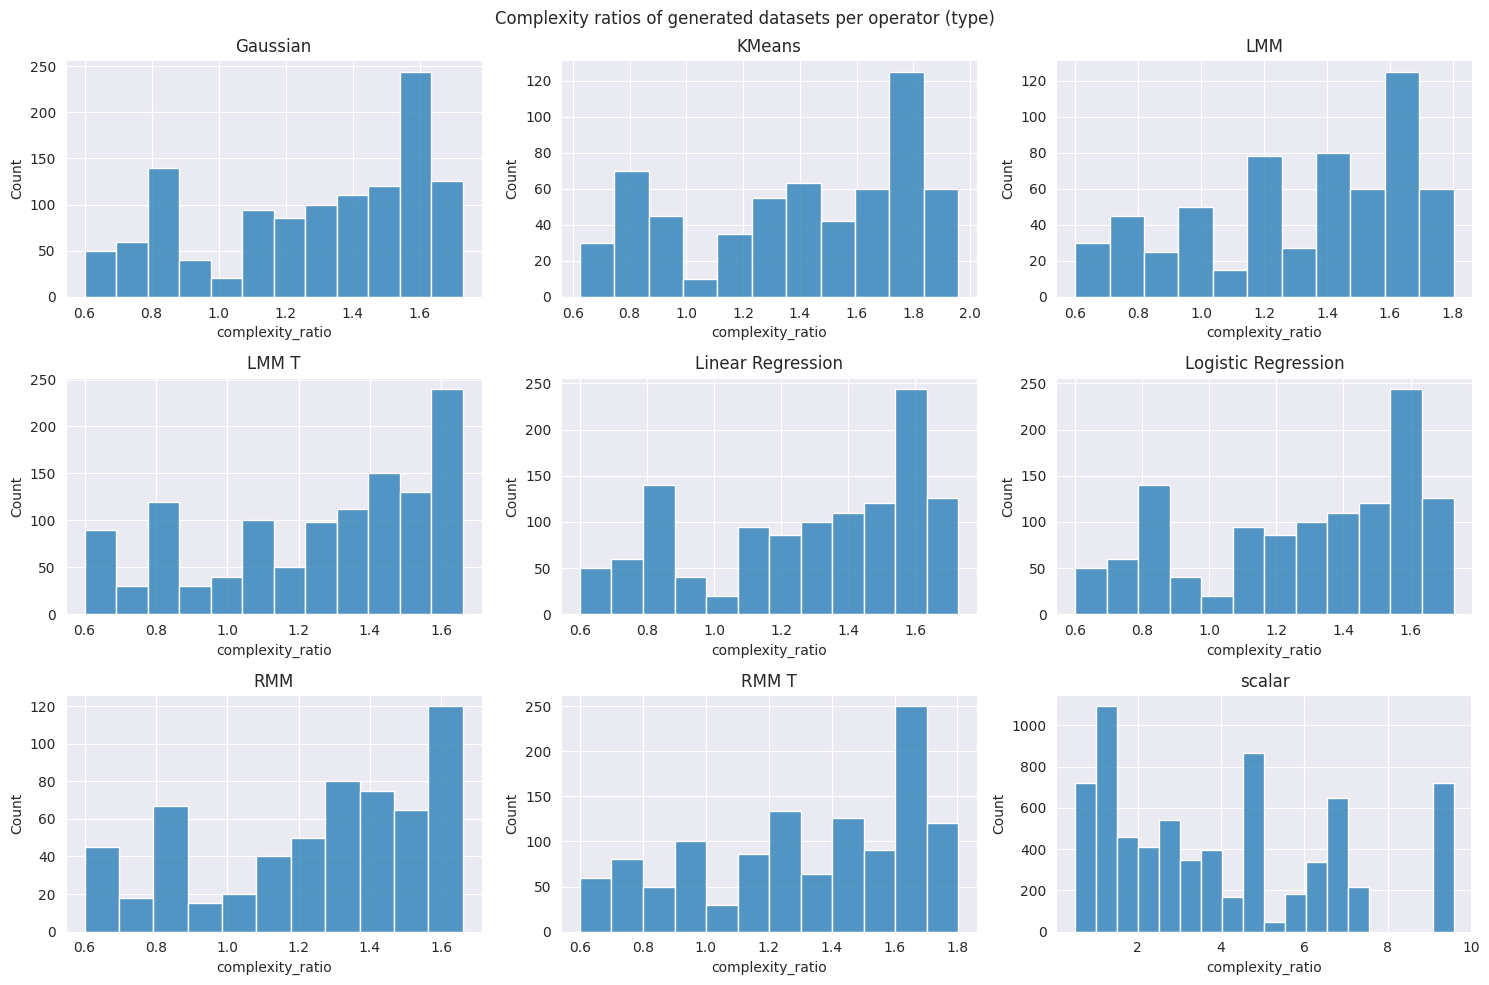

In [7]:
fig, axs = plt.subplots((len(df.operator_type.unique()))//3, 3,figsize=(15, 10), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.4, top=0.85)

axs = axs.flatten()
for ax, (group, dfsub) in zip(axs, df[df.model!='materialized'].groupby('operator_type')):
    sns.histplot(data=dfsub, x='complexity_ratio', ax=ax)
    ax.set_title(group)
fig.suptitle("Complexity ratios of generated datasets per operator (type)")
plt.tight_layout()
plt.savefig('fig.png')

In [12]:
df[(~df.operator_original.apply(lambda x: 'dimension' in x)) & (df.operator_original.apply(lambda x: 'fail' in x))].head()

,dataset,join,operator,model,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,complexity,selectivity,times,num_cores,data_characteristics,profile_times,times_std,times_mean,operator_original,operator_type,complexity_ratio
48,/data/amalur_generated_data/sigmod24/100k/n_R=...,preset,KMeans,materialized,11.73862,10.0,97666,97667,59024528.0,1.00001,[0],-1,"{'r_T': 100000, 'c_T': 50, 'r_S': 90000, 'c_S'...",NaN,-1,0.0,"KMeans= fail: shapes (97666,3) and (1,3) not a...",KMeans,1.000000
49,/data/amalur_generated_data/sigmod24/100k/n_R=...,preset,KMeans,factorized,11.73862,10.0,97666,97667,36777908.0,1.00001,[0],-1,"{'r_T': 100000, 'c_T': 50, 'r_S': 90000, 'c_S'...",NaN,-1,0.0,"KMeans= fail: shapes (97666,3) and (1,3) not a...",KMeans,1.604891
51,/data/amalur_generated_data/sigmod24/100k/n_R=...,preset,Logistic Regression,materialized,11.73862,10.0,97666,97667,17197782.0,1.00001,[0],-1,"{'r_T': 100000, 'c_T': 50, 'r_S': 90000, 'c_S'...",NaN,-1,0.0,"Logistic Regression= fail: shapes (97666,3) an...",Logistic Regression,1.000000
53,/data/amalur_generated_data/sigmod24/100k/n_R=...,preset,Logistic Regression,factorized,11.73862,10.0,97666,97667,11758222.0,1.00001,[0],-1,"{'r_T': 100000, 'c_T': 50, 'r_S': 90000, 'c_S'...",NaN,-1,0.0,"Logistic Regression= fail: shapes (97666,3) an...",Logistic Regression,1.462618
102,/data/amalur_generated_data/sigmod24/100k/n_R=...,preset,KMeans,materialized,5.00000,5.0,100000,120000,38640008.0,1.20000,[0],-1,"{'r_T': 100000, 'c_T': 30, 'r_S': 100000, 'c_S...",NaN,-1,0.0,"KMeans= fail: shapes (100000,3) and (1,3) not ...",KMeans,1.000000
